In [87]:
import matplotlib.pyplot as plt
import numpy as np

from neurolib.models.wc import WCModel
from neurolib.control.optimal_control import oc_wc, cost_functions

# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


$\Huge \frac{d}{du} f = \frac{\partial f}{\partial u} + \lambda^T \frac{\partial h}{\partial u}$

$\Huge \dot{\lambda}^T \frac{\partial h}{\partial \dot{x}} = \frac{\partial f}{\partial x} + \lambda^T \frac{\partial h}{\partial x} $

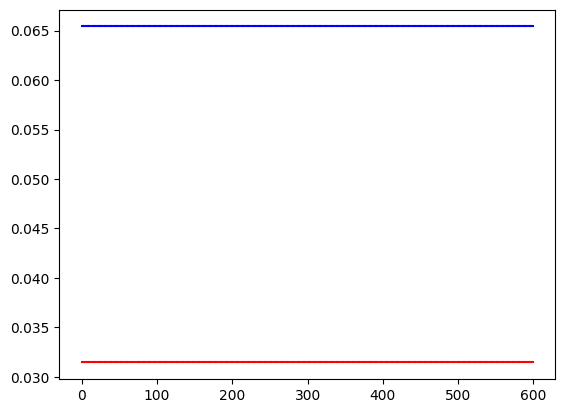

In [148]:
T =  60.
N = 2
cmat = np.zeros((N,N))
cmat[1,0] = 1.
cmat[0,1] = 1.


wc = WCModel(Cmat=cmat, Dmat=np.zeros(cmat.shape))
wc.params.duration = T
wc.params.dt = 0.1
wc.params.sigma_ou = 0.0

wc.params.exc_ext_baseline = 1.0
wc.params.inh_ext_baseline = 1.0
wc.params.exc_init = np.array( [[0.1]] )
wc.params.inh_init = np.array( [[0.1]] )
wc.run()

wc.params.exc_init = np.array( [[ wc.exc[0,-1] ], [wc.exc[1,-1] ]] )
wc.params.inh_init = np.array( [[ wc.inh[0,-1] ], [wc.inh[1,-1] ]] )
wc.run()

time = np.arange(0, T, wc.params.dt)
target_period = 10.

if False:
    u = np.zeros((wc.exc.shape))
    u[0,2] = 4.
    u[0,5] = -2.
    u[0,6] = 3.
    u[0,8] = -1.
    u[0,9] = 1.

uzero = np.zeros((N, 2, wc.exc.shape[1]))
ustart = uzero.copy()
ustart[0,0,:] = 1.
#wc.params.exc_ext = 0.
wc.run()

plt.plot(wc.exc[0,:], color="red")
plt.plot(wc.exc[1,:], color="red", linestyle=":")
plt.plot(wc.inh[0,:], color="blue")
plt.plot(wc.inh[1,:], color="blue", linestyle=":")
plt.show()

Optimal control with target time series


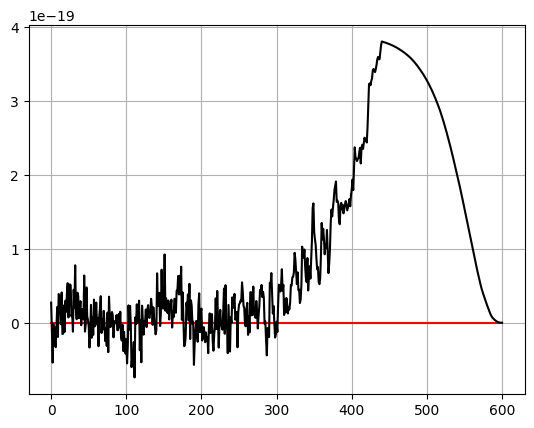

In [92]:
target = np.zeros(( N, 2, wc.exc.shape[1]+1 ))
target[0,0,1:] = wc.exc[0,:]
target[0,0,0] = wc.params.exc_init[0,0]
target[1,0,1:] = wc.exc[0,:]
target[1,0,0] = wc.params.exc_init[0,0]
target[0,1,1:] = wc.inh[0,:]
target[0,1,0] = wc.params.inh_init[0,0]
target[1,1,1:] = wc.inh[0,:]
target[1,1,0] = wc.params.inh_init[0,0]
wc.params.exc_ext = 0.

wc_controlled = oc_wc.OcWc(wc, target, print_array=np.arange(0,1000,100), cost_interval=(0,None), control_interval=(0,None))
wc_controlled.weights["w_2"] = 0.
wc_controlled.weights["w_p"] = 1.
wc_controlled.weights["w_f"] = 0.

if True:
    grad_an = wc_controlled.compute_gradient()
    grad_num = wc_controlled.compute_gradient_num()

    plt.plot(grad_an[1,0,:], color="red")
    plt.plot(grad_num[1,0,:], color="black")
    plt.grid()
    plt.show()

Optimal control with target time series
Compute control for a deterministic system
Cost in iteration 0: 0.019651405008860503
Converged in iteration 64 with cost 0.018253399062739758
Final cost : 0.018253399062739758
Compute control for a deterministic system
Cost in iteration 0: 0.018253399062739758
Converged in iteration 1 with cost 0.018253399062739758
Final cost : 0.018253399062739758
Compute control for a deterministic system
Cost in iteration 0: 0.018253399062739758
Converged in iteration 1 with cost 0.018253399062739758
Final cost : 0.018253399062739758
Compute control for a deterministic system
Cost in iteration 0: 0.018253399062739758
Converged in iteration 1 with cost 0.018253399062739758
Final cost : 0.018253399062739758


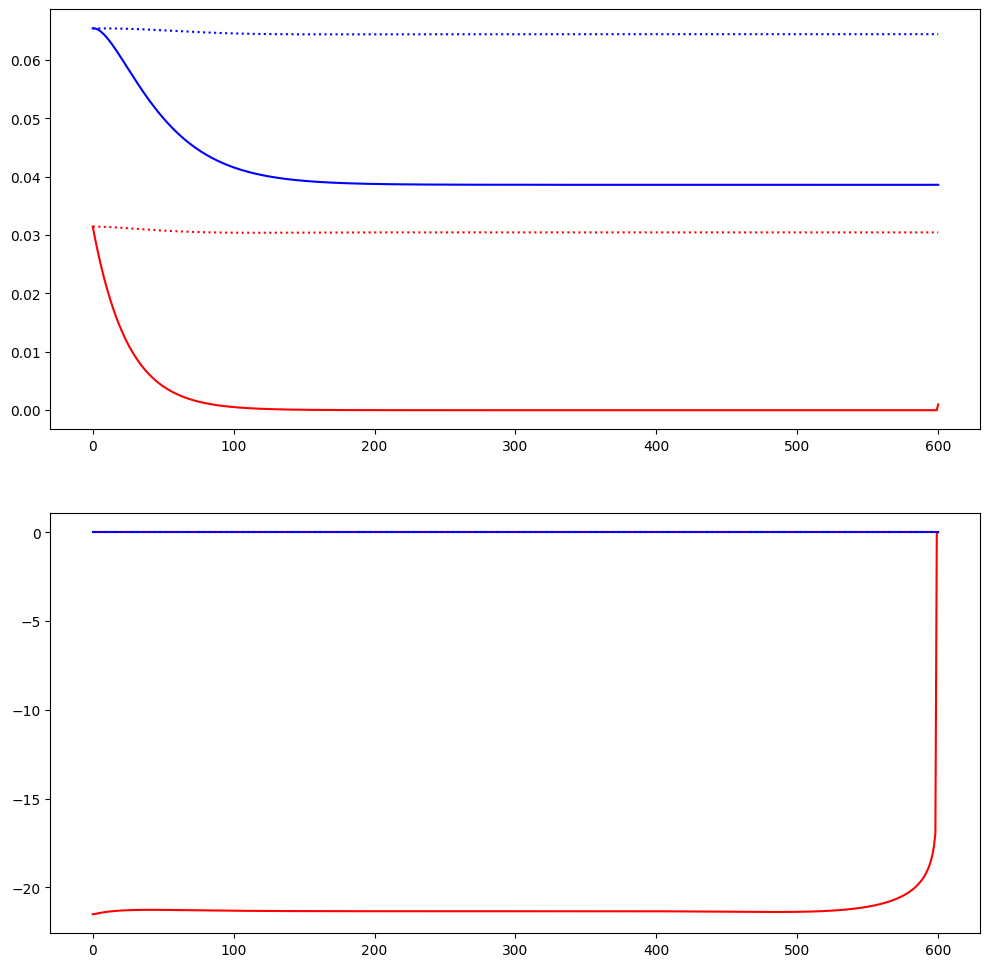

In [149]:
controlmat = np.zeros((2,2))
controlmat[0,0] = 1
costmat = np.zeros((2,2))
costmat[1,0] = 1
wc.params.exc_ext = 0.#u_rect[:,0,:]

wc_controlled = oc_wc.OcWc(wc, target, print_array=np.arange(0,1000,100), cost_interval=(0,None), control_interval=(0,None),
                              control_matrix=controlmat, cost_matrix=costmat)
wc_controlled.weights["w_2"] = 0.
wc_controlled.weights["w_p"] = 1.

for k in range(4):
    for exp in np.arange(-1, 0, 2):
        wc_controlled.zero_step_encountered = False
        wc_controlled.step = 10.**exp
        wc_controlled.optimize(1000)

    if False:
        grad_an = wc_controlled.compute_gradient()
        grad_num = wc_controlled.compute_gradient_num()

        fig, ax = plt.subplots(1,2, figsize=(16,6))
        ax[0].plot(grad_an[0,0,:], color="red")
        ax[0].plot(grad_an[0,1,:], color="blue")
        ax[1].plot(grad_an[1,0,:], color="red")
        ax[1].plot(grad_an[1,1,:], color="blue")
        ax[0].plot(grad_num[0,0,:], color="red", linestyle=":", linewidth=3)
        ax[0].plot(grad_num[0,1,:], color="blue", linestyle=":", linewidth=3)
        ax[1].plot(grad_num[1,0,:], color="red", linestyle=":", linewidth=3)
        ax[1].plot(grad_num[1,1,:], color="blue", linestyle=":", linewidth=3)
        plt.show()

xs = wc_controlled.get_xs()
control = wc_controlled.control

fig, ax = plt.subplots(2,1, figsize=(12,12))
ax[0].plot(xs[0,0,:], color="red")
ax[0].plot(xs[0,1,:], color="blue")
ax[0].plot(xs[1,0,:], color="red", linestyle=":")
ax[0].plot(xs[1,1,:], color="blue", linestyle=":")

ax[1].plot(control[0,0,:], color="red")
ax[1].plot(control[0,1,:], color="blue")
ax[1].plot(control[1,0,:], color="red", linestyle=":")
ax[1].plot(control[1,1,:], color="blue", linestyle=":")
plt.show()

u_cos_opt = wc_controlled.control[:,:,:]

Optimal control with target oscillation period


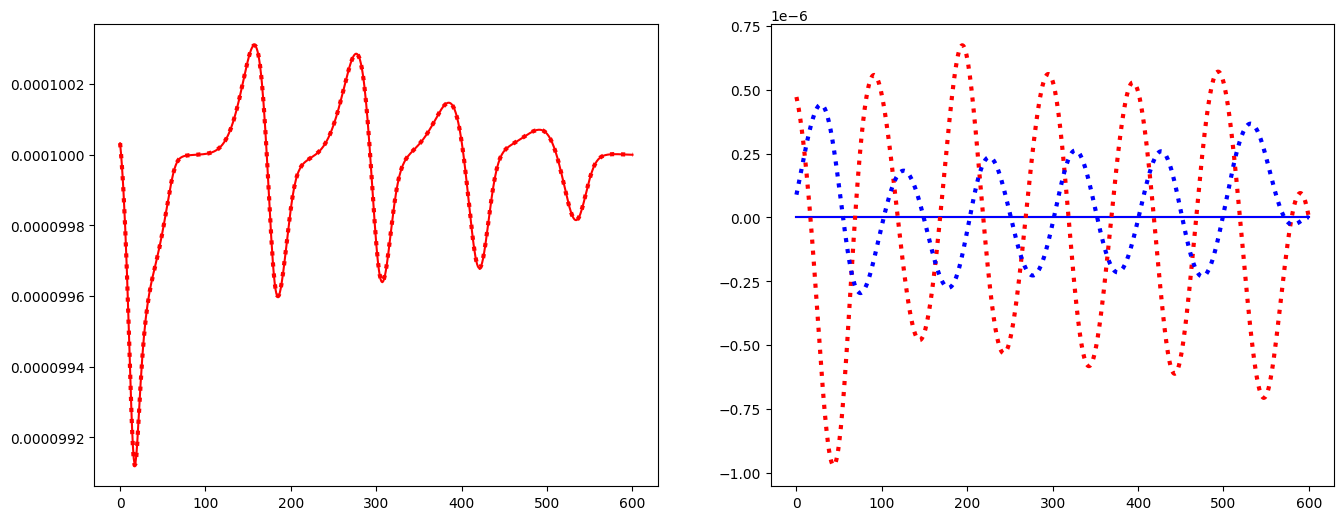

Compute control for a deterministic system
Cost in iteration 0: 0.00300478151265675
Final cost : 1.3406822124133182e-07


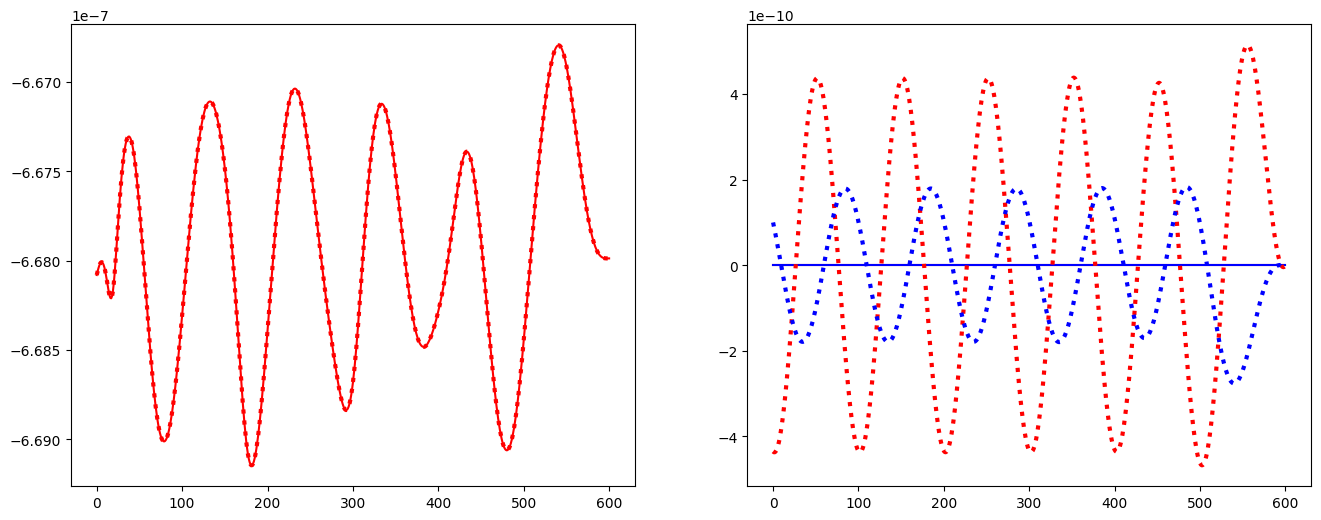

Compute control for a deterministic system
Cost in iteration 0: 1.3406822124133182e-07
Final cost : -2.6480118472787617e-18


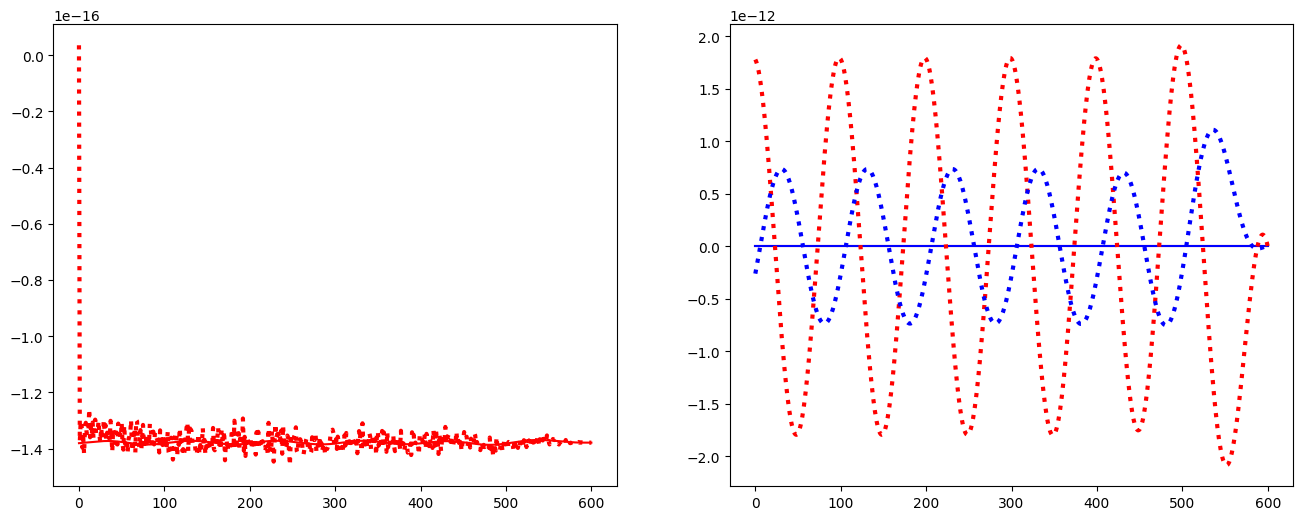

Compute control for a deterministic system
Cost in iteration 0: -2.6480118472787617e-18
Converged in iteration 10 with cost -2.6480118472787617e-18
Final cost : -2.6480118472787617e-18


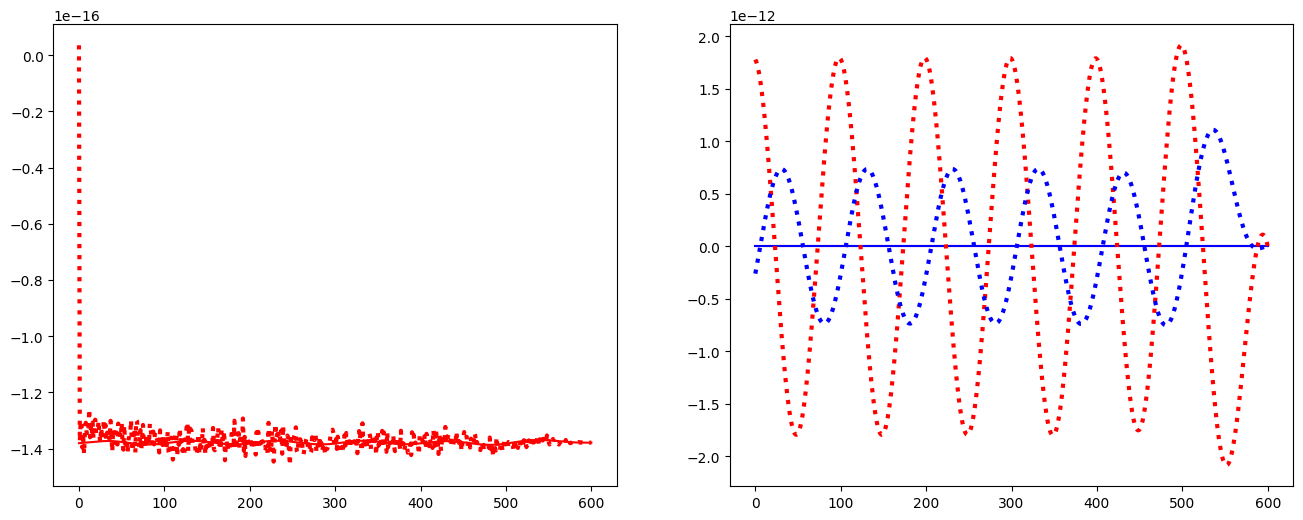

Compute control for a deterministic system
Cost in iteration 0: -2.6480118472787617e-18
Converged in iteration 1 with cost -2.6480118472787617e-18
Final cost : -2.6480118472787617e-18


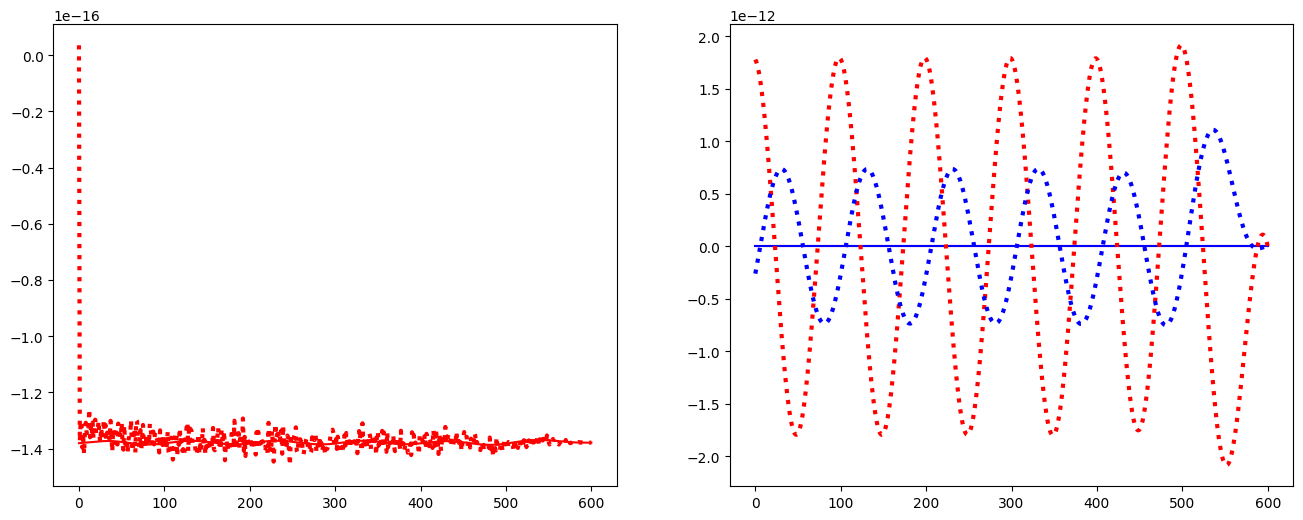

Compute control for a deterministic system
Cost in iteration 0: -2.6480118472787617e-18
Converged in iteration 1 with cost -2.6480118472787617e-18
Final cost : -2.6480118472787617e-18


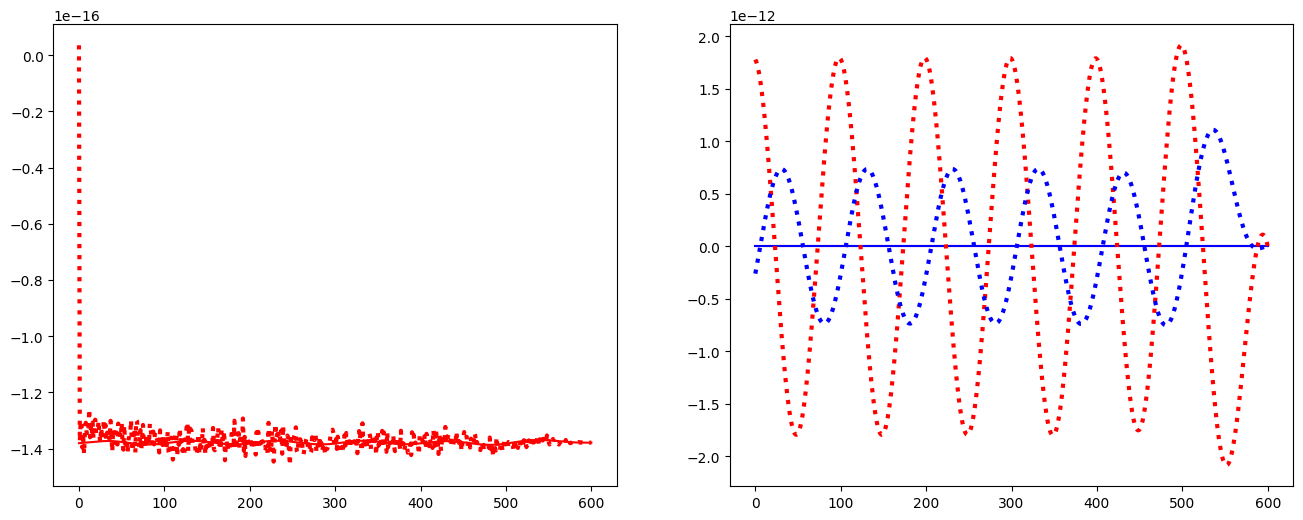

Compute control for a deterministic system
Cost in iteration 0: -2.6480118472787617e-18
Converged in iteration 1 with cost -2.6480118472787617e-18
Final cost : -2.6480118472787617e-18


In [151]:
ui = 0 
wc.params.exc_ext = ustart[:,0,:]

wc_controlled = oc_wc.OcWc(wc, target_period, print_array=np.arange(0,1000,100),
                                cost_interval=(0,None), control_interval=(0,None), control_matrix=controlmat, cost_matrix=costmat, grad_method=0)
wc_controlled.weights["w_2"] = 1e-4
wc_controlled.weights["w_p"] = 0.
wc_controlled.weights["w_f"] = 1.

#plt.plot(wc_controlled.get_xs()[0,0,:], color="red")
#plt.plot(wc_controlled.get_xs()[1,0,:], color="red", linestyle=":")
#plt.show()

for k in range(6):
    grad_an = wc_controlled.compute_gradient()
    grad_num = wc_controlled.compute_gradient_num()

    fig, ax = plt.subplots(1,2, figsize=(16,6))
    ax[0].plot(grad_an[0,0,:], color="red")
    #ax[0].plot(grad_an[0,1,:], color="blue")
    ax[1].plot(grad_an[1,0,:], color="red")
    ax[1].plot(grad_an[1,1,:], color="blue")
    ax[0].plot(grad_num[0,0,:], color="red", linestyle=":", linewidth=3)
    #ax[0].plot(grad_num[0,1,:], color="blue", linestyle=":", linewidth=3)
    ax[1].plot(grad_num[1,0,:], color="red", linestyle=":", linewidth=3)
    ax[1].plot(grad_num[1,1,:], color="blue", linestyle=":", linewidth=3)
    plt.show()

    wc_controlled.optimize(10)

xs = wc_controlled.get_xs()
control = wc_controlled.control

if False:
    fig, ax = plt.subplots(2,1, figsize=(12,12))
    ax[0].plot(xs[0,0,:], color="red")
    ax[0].plot(xs[0,1,:], color="blue")
    ax[0].plot(xs[1,0,:], color="red", linestyle=":")
    ax[0].plot(xs[1,1,:], color="blue", linestyle=":")

    ax[1].plot(control[0,0,:], color="red")
    ax[1].plot(control[0,1,:], color="blue")
    ax[1].plot(control[1,0,:], color="red", linestyle=":")
    ax[1].plot(control[1,1,:], color="blue", linestyle=":")
    plt.show()

Optimal control with target oscillation period


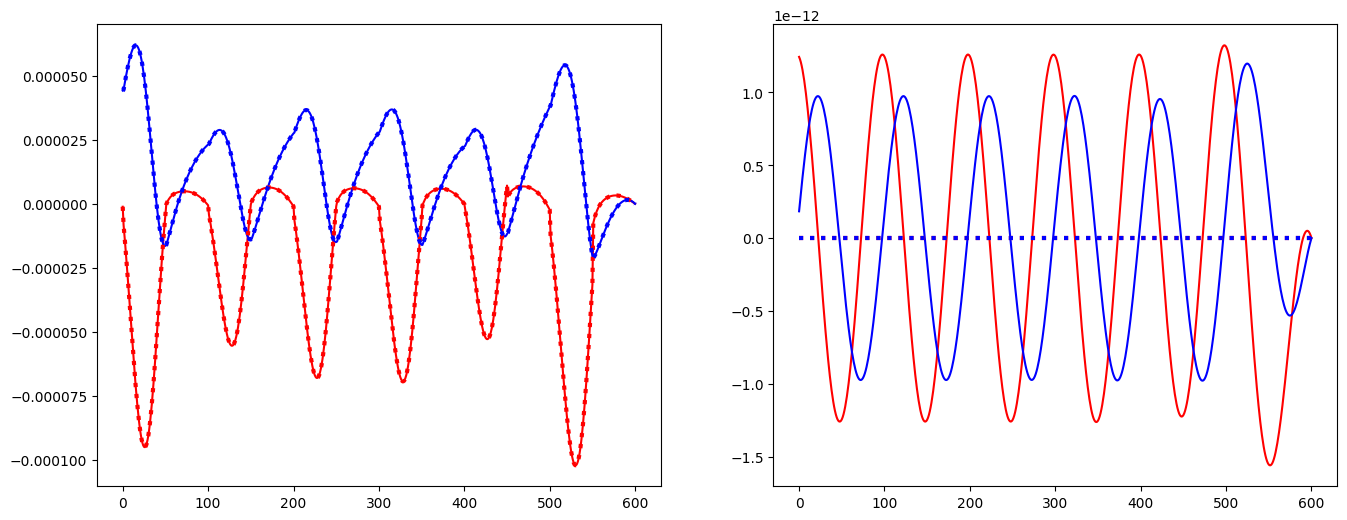

Compute control for a deterministic system
Cost in iteration 0: -0.00023199819268617222
Final cost : -0.0165321509082028


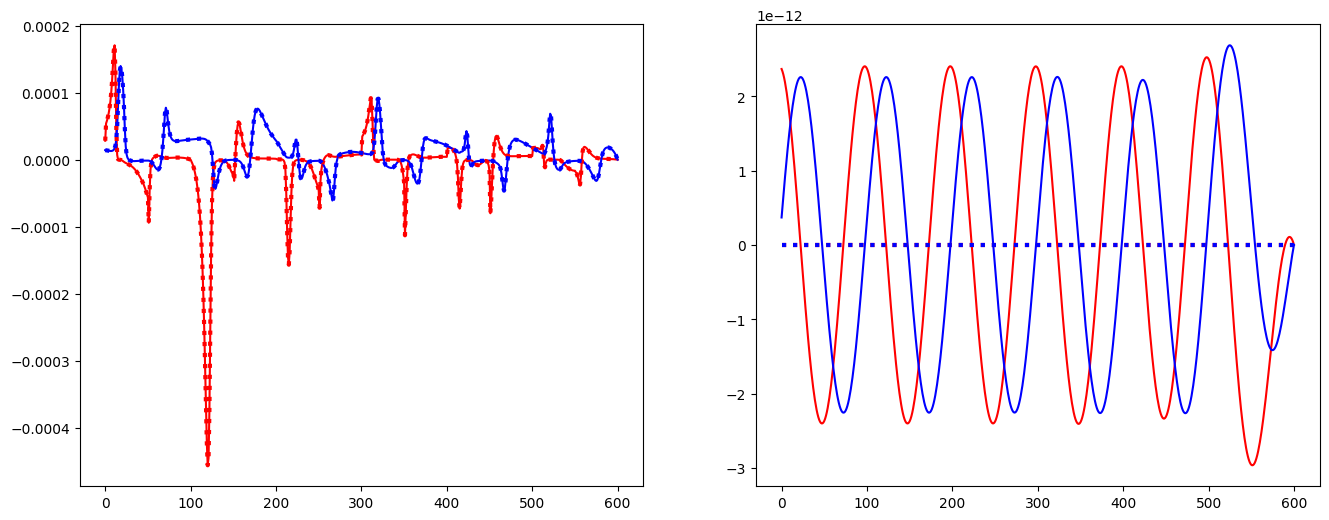

Compute control for a deterministic system
Cost in iteration 0: -0.0165321509082028
nan in gradient, break
Final cost : -0.036939571055954884


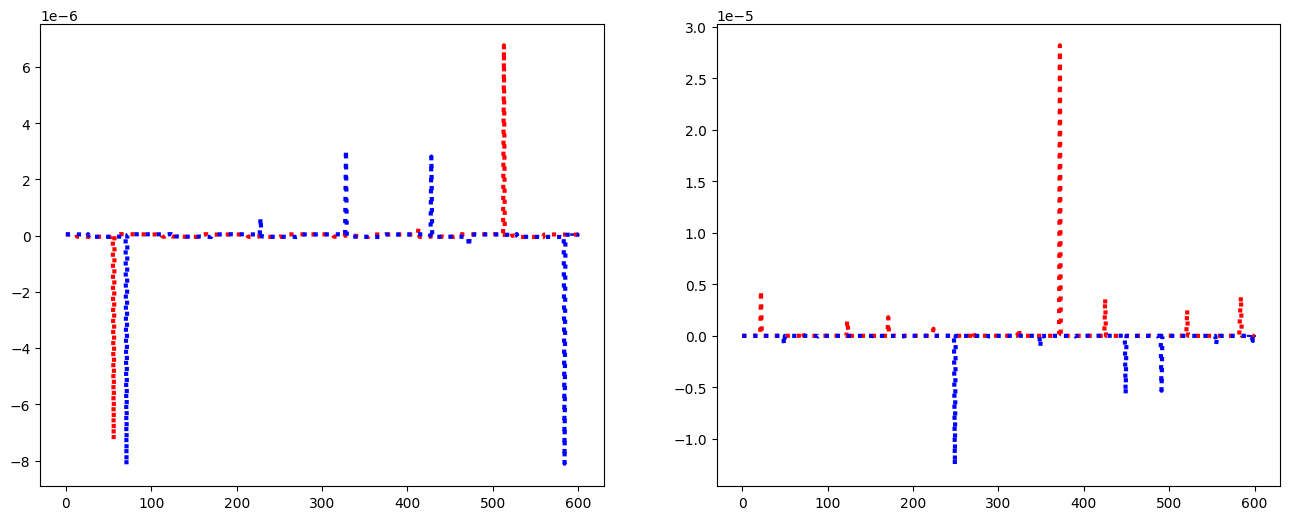

Compute control for a deterministic system
Cost in iteration 0: -0.036939571055954884
nan in gradient, break
Final cost : -0.036939571055954884


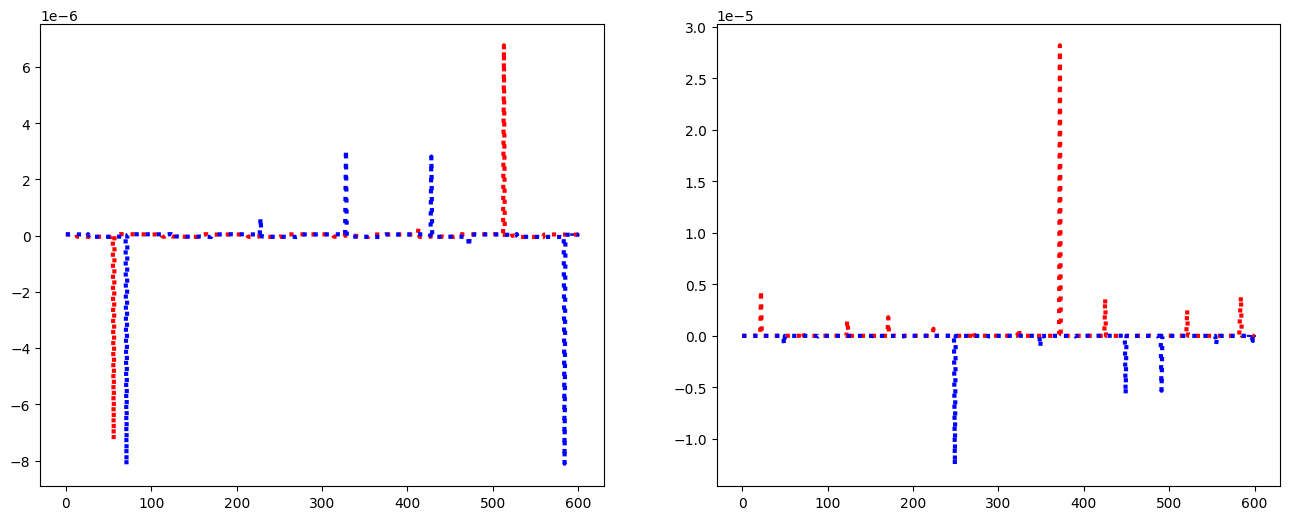

Compute control for a deterministic system
Cost in iteration 0: -0.036939571055954884
nan in gradient, break
Final cost : -0.036939571055954884


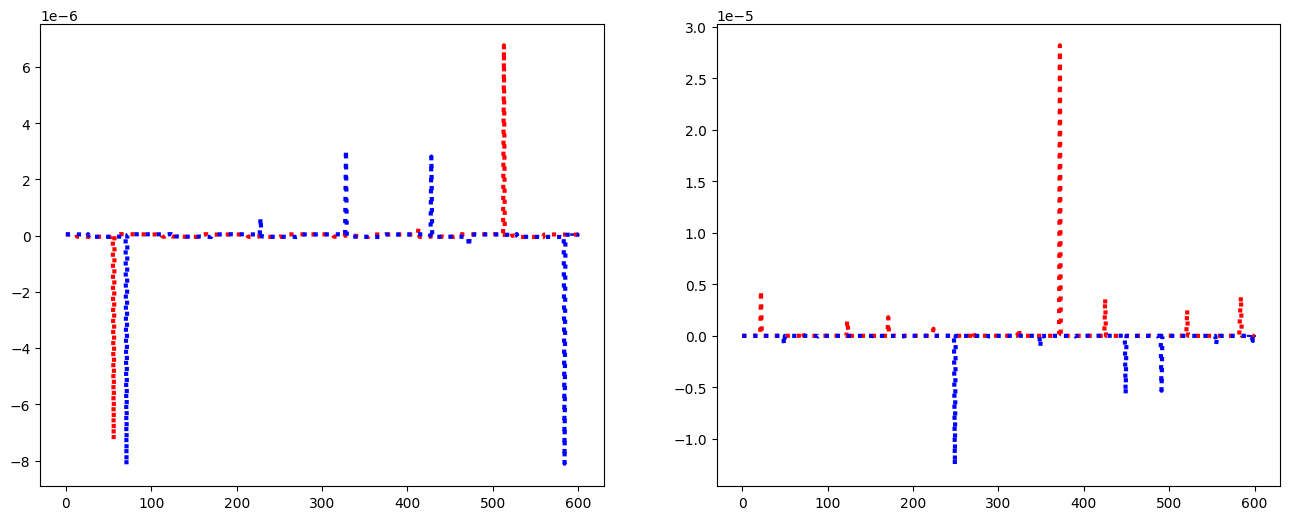

Compute control for a deterministic system
Cost in iteration 0: -0.036939571055954884
nan in gradient, break
Final cost : -0.036939571055954884


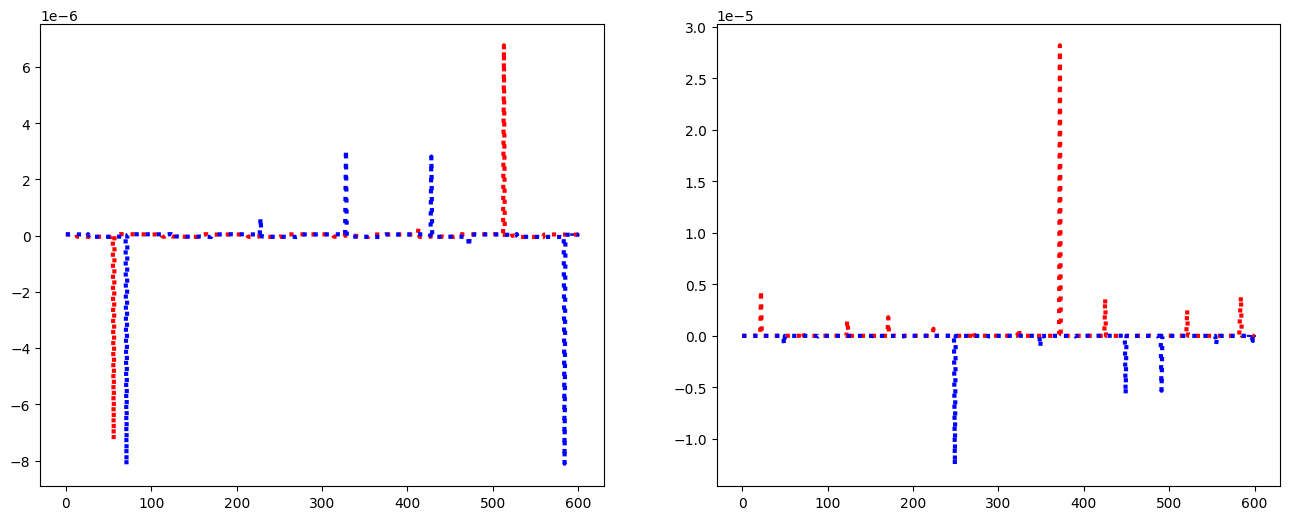

Compute control for a deterministic system
Cost in iteration 0: -0.036939571055954884
nan in gradient, break
Final cost : -0.036939571055954884


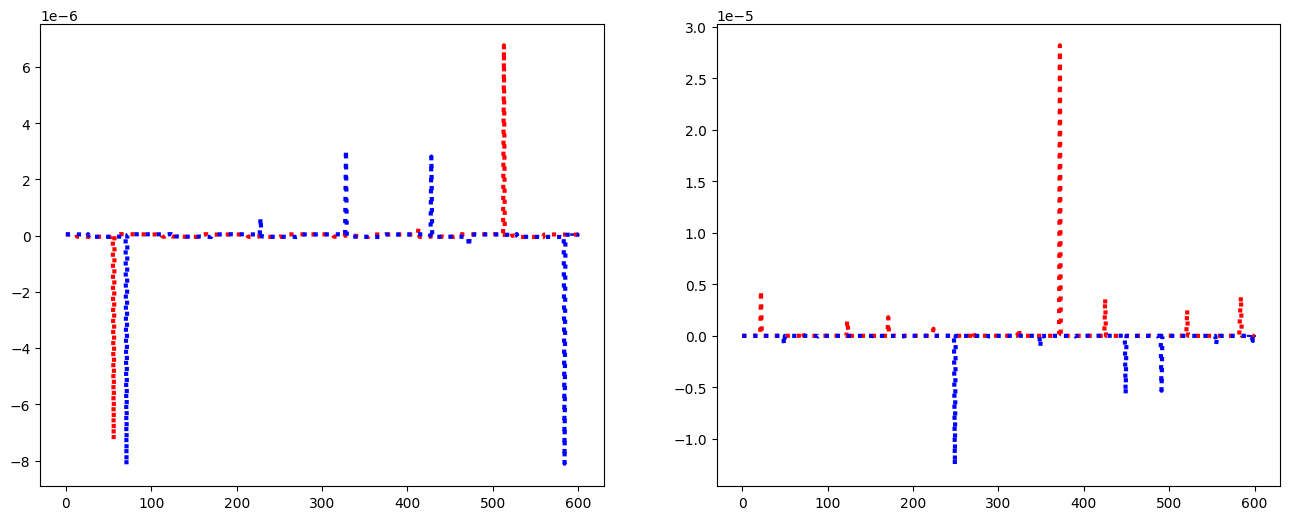

Compute control for a deterministic system
Cost in iteration 0: -0.036939571055954884
nan in gradient, break
Final cost : -0.036939571055954884


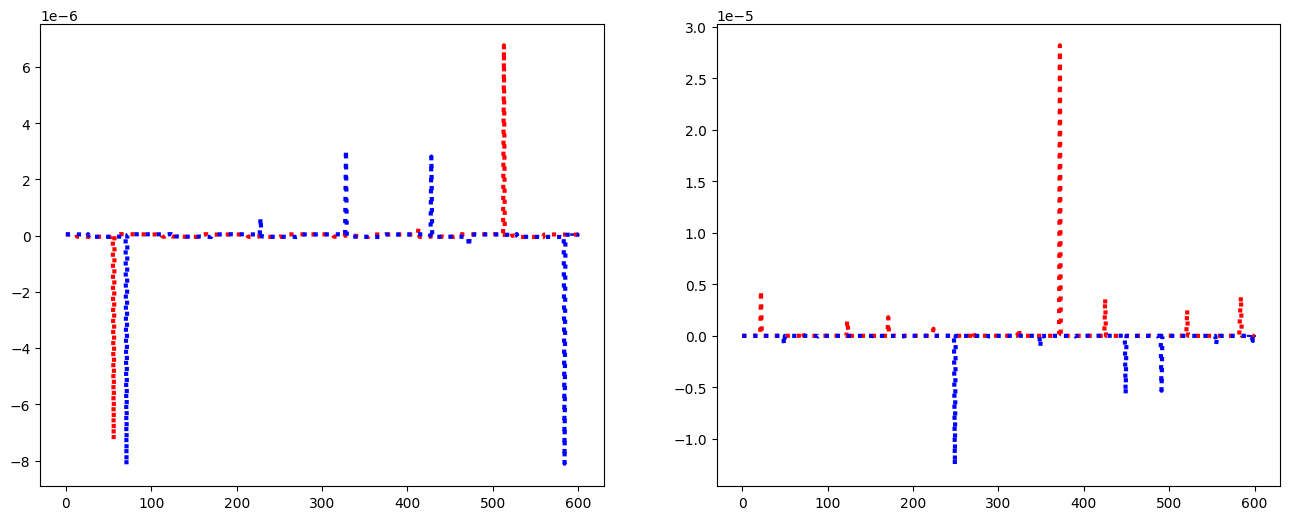

Compute control for a deterministic system
Cost in iteration 0: -0.036939571055954884
nan in gradient, break
Final cost : -0.036939571055954884


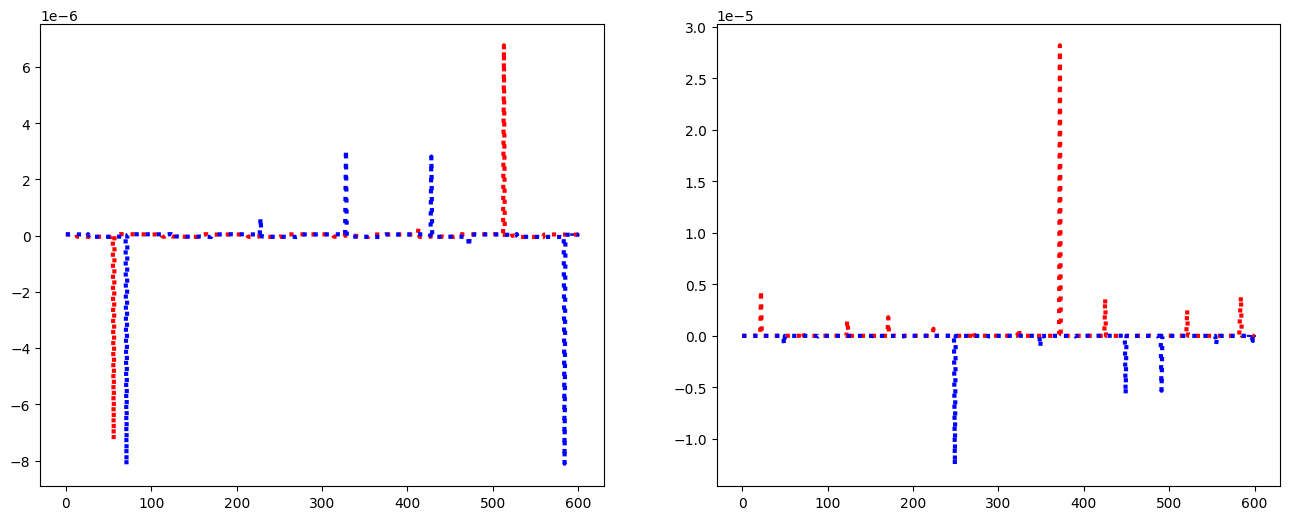

Compute control for a deterministic system
Cost in iteration 0: -0.036939571055954884
nan in gradient, break
Final cost : -0.036939571055954884


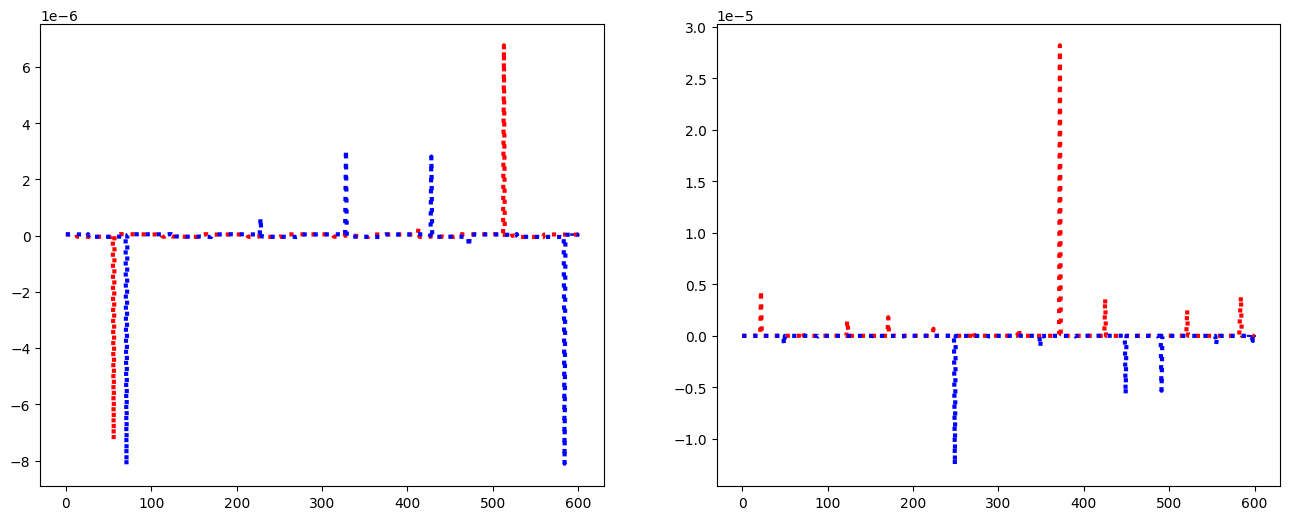

Compute control for a deterministic system
Cost in iteration 0: -0.036939571055954884
nan in gradient, break
Final cost : -0.036939571055954884


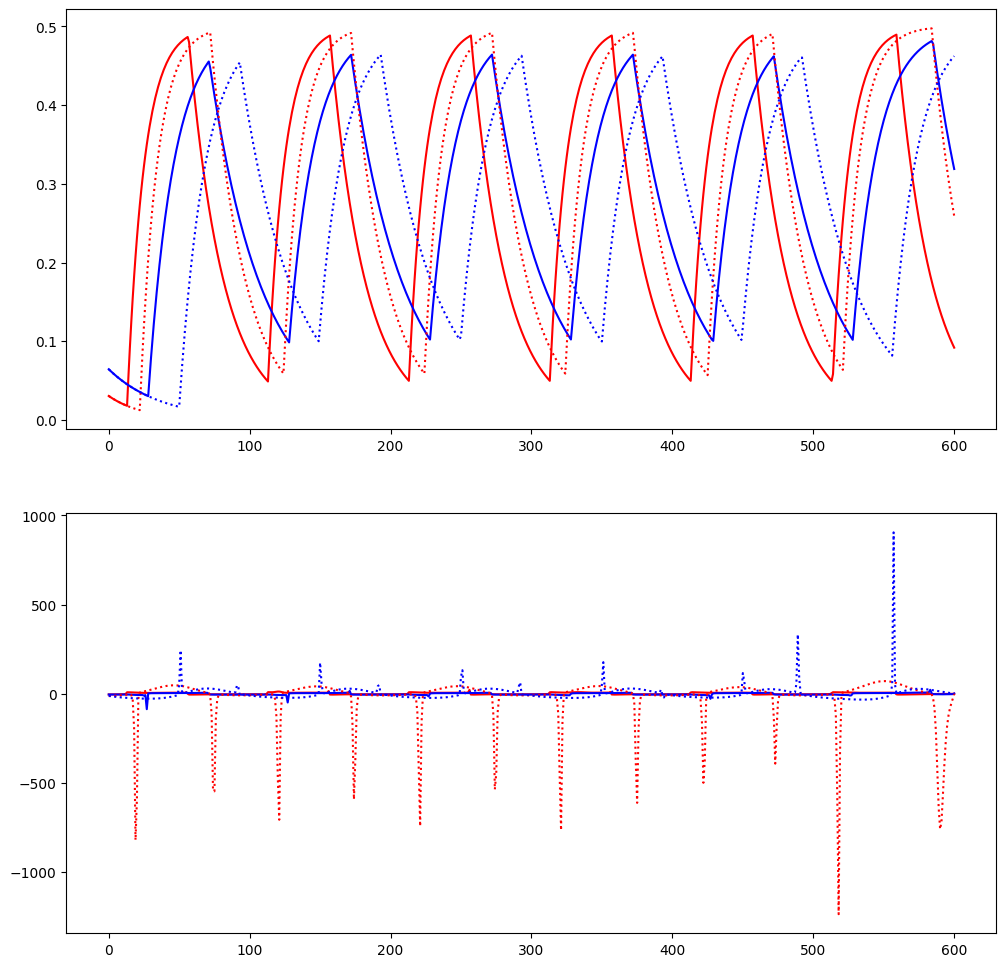

In [147]:
ui = 0 
wc.params.x_ext = uzero

wc_controlled = oc_wc.OcWc(wc, target_period, print_array=np.arange(0,1000,100),
                                cost_interval=(0,None), control_interval=(0,None), grad_method=0)
wc_controlled.weights["w_2"] = 1e-5
wc_controlled.weights["w_p"] = 0.
wc_controlled.weights["w_f"] = 1.

#plt.plot(wc_controlled.get_xs()[0,0,:], color="red")
#plt.plot(wc_controlled.get_xs()[1,0,:], color="red", linestyle=":")
#plt.show()

for k in range(10):
    grad_an = wc_controlled.compute_gradient()
    grad_num = wc_controlled.compute_gradient_num()

    fig, ax = plt.subplots(1,2, figsize=(16,6))
    ax[0].plot(grad_an[0,0,:], color="red")
    ax[0].plot(grad_an[0,1,:], color="blue")
    ax[1].plot(grad_an[1,0,:], color="red")
    ax[1].plot(grad_an[1,1,:], color="blue")
    ax[0].plot(grad_num[0,0,:], color="red", linestyle=":", linewidth=3)
    ax[0].plot(grad_num[0,1,:], color="blue", linestyle=":", linewidth=3)
    ax[1].plot(grad_num[1,0,:], color="red", linestyle=":", linewidth=3)
    ax[1].plot(grad_num[1,1,:], color="blue", linestyle=":", linewidth=3)
    plt.show()

    wc_controlled.optimize(10)

xs = wc_controlled.get_xs()
control = wc_controlled.control

if True:
    fig, ax = plt.subplots(2,1, figsize=(12,12))
    ax[0].plot(xs[0,0,:], color="red")
    ax[0].plot(xs[0,1,:], color="blue")
    ax[0].plot(xs[1,0,:], color="red", linestyle=":")
    ax[0].plot(xs[1,1,:], color="blue", linestyle=":")

    ax[1].plot(control[0,0,:], color="red")
    ax[1].plot(control[0,1,:], color="blue")
    ax[1].plot(control[1,0,:], color="red", linestyle=":")
    ax[1].plot(control[1,1,:], color="blue", linestyle=":")
    plt.show()

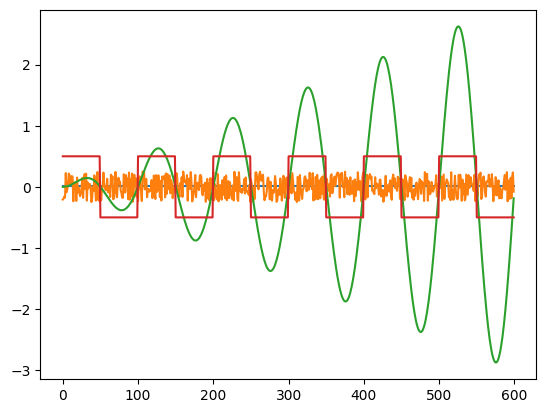

In [142]:
u_rand = np.zeros((uzero.shape))
u_rand[0,0,:] = 0.5 * np.random.rand(uzero.shape[2]) - 0.25

u_sine = np.zeros((uzero.shape))
u_sine[0,0,:] = np.sin(2.*np.pi*np.arange(0,T, wc.params.dt)/target_period)
for t in range(u_sine.shape[2]):
    u_sine[0,0,t] *= 1e-2 * t / u_sine.shape[1]

u_rect = np.zeros((uzero.shape))
i = 0
while i < uzero.shape[2]:
    u_rect[0,0,i:i+50] = 0.5
    u_rect[0,0,i+50:i+100] = -0.5
    i += 100

u_inits = [0.01 * np.ones(uzero.shape), u_rand, u_sine, u_rect]#, u_cos_opt]
res_cost = np.zeros(( 3, len(u_inits)))
res_control = [[None for x0 in range(res_cost.shape[1])] for x1 in range(3) ]
res_state = [[None for x0 in range(res_cost.shape[1])] for x1 in range(3) ]

for u_ in u_inits:
    plt.plot(u_[0,0,:])

plt.show()

Optimal control with target oscillation period
Compute control for a deterministic system
Cost in iteration 0: -3.563689513849541e-14
Converged in iteration 1 with cost -3.563689513849541e-14
Final cost : -3.563689513849541e-14
Compute control for a deterministic system
Cost in iteration 0: -3.563689513849541e-14
Converged in iteration 1 with cost -3.563689513849541e-14
Final cost : -3.563689513849541e-14
Compute control for a deterministic system
Cost in iteration 0: -3.563689513849541e-14
Converged in iteration 2 with cost -3.563689513849541e-14
Final cost : -3.563689513849541e-14
Compute control for a deterministic system
Cost in iteration 0: -3.563689513849541e-14
Converged in iteration 2 with cost -3.563689513849541e-14
Final cost : -3.563689513849541e-14
Compute control for a deterministic system
Cost in iteration 0: -3.563689513849541e-14
Converged in iteration 1 with cost -3.563689513849541e-14
Final cost : -3.563689513849541e-14
Compute control for a deterministic system
Cost 

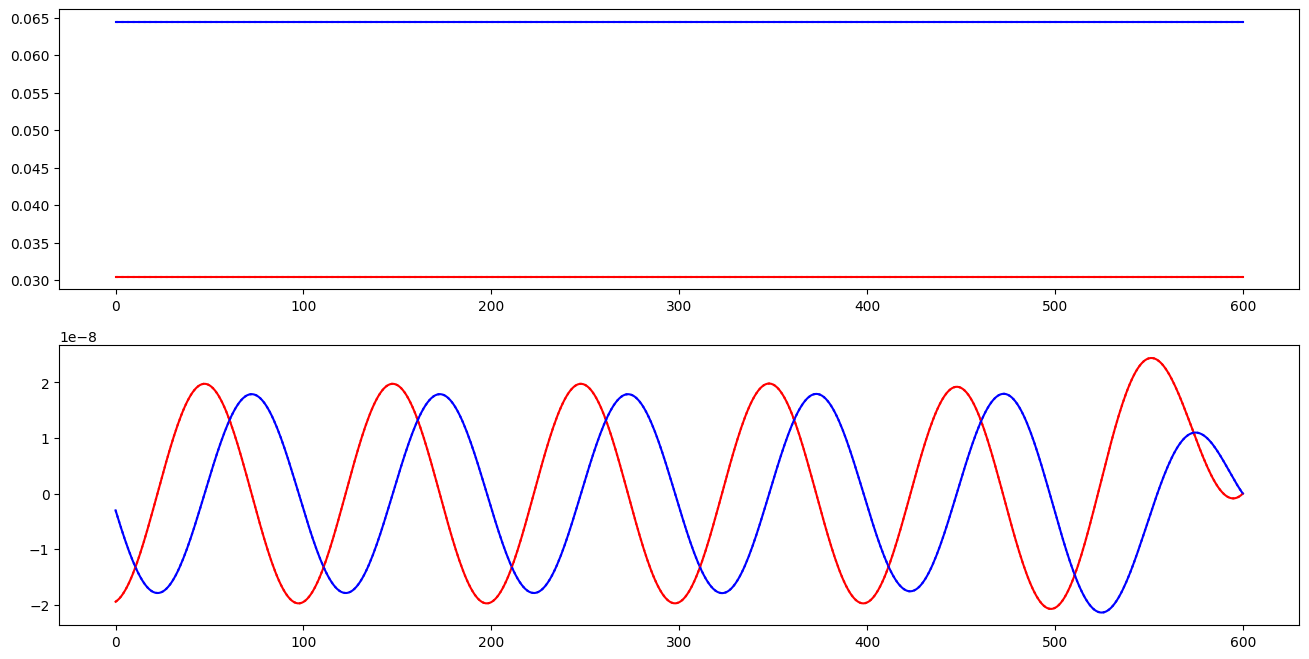

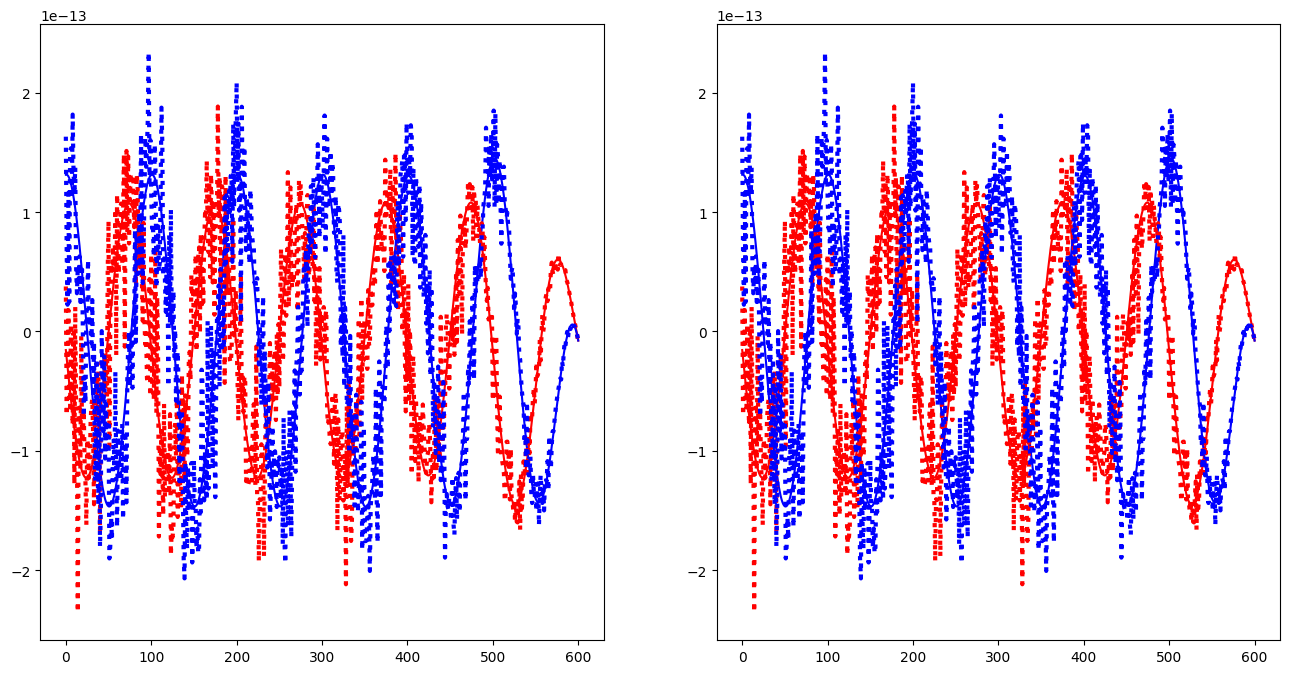

MAX GRADIENT =  1.4699169448845613e-13
Optimal control with target oscillation period
Compute control for a deterministic system
Cost in iteration 0: -3.5636894784417653e-14
Final cost : -3.563689478862722e-14
Compute control for a deterministic system
Cost in iteration 0: -3.563689478862722e-14
Converged in iteration 1 with cost -3.563689478862722e-14
Final cost : -3.563689478862722e-14
Compute control for a deterministic system
Cost in iteration 0: -3.563689478862722e-14
Converged in iteration 2 with cost -3.563689478862722e-14
Final cost : -3.563689478862722e-14
Compute control for a deterministic system
Cost in iteration 0: -3.563689478862722e-14
Converged in iteration 2 with cost -3.563689478862722e-14
Final cost : -3.563689478862722e-14
Compute control for a deterministic system
Cost in iteration 0: -3.563689478862722e-14
Converged in iteration 1 with cost -3.563689478862722e-14
Final cost : -3.563689478862722e-14
Compute control for a deterministic system
Cost in iteration 0: -3

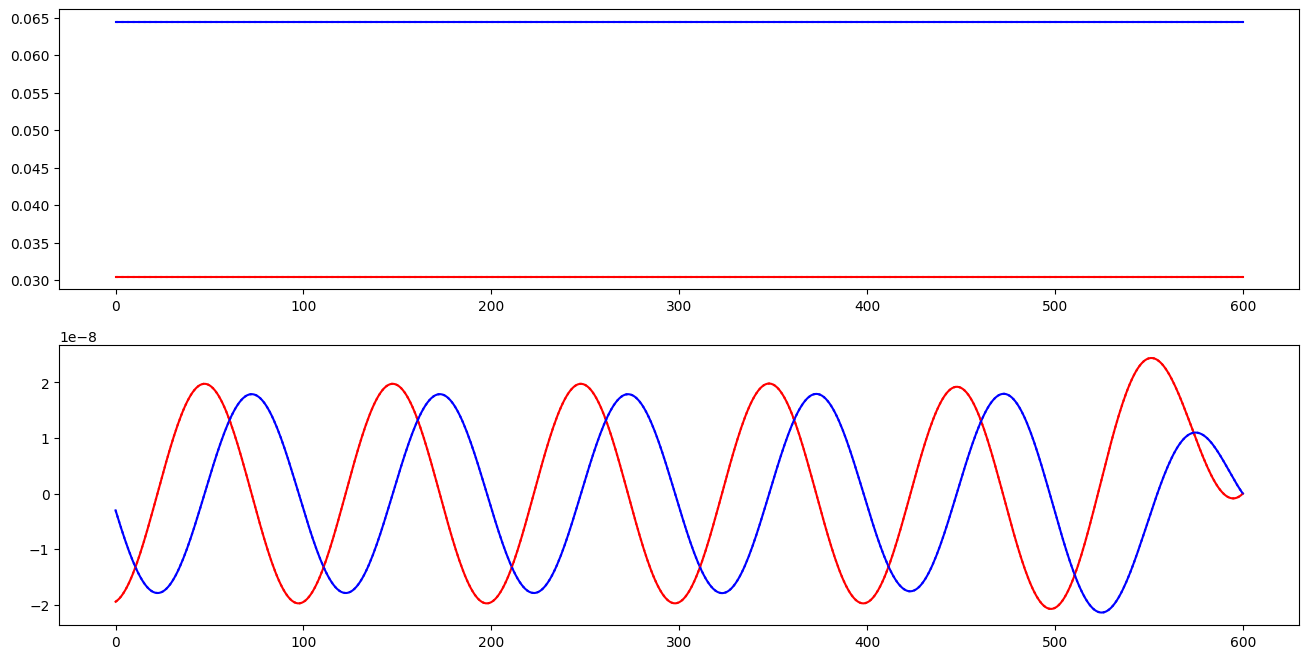

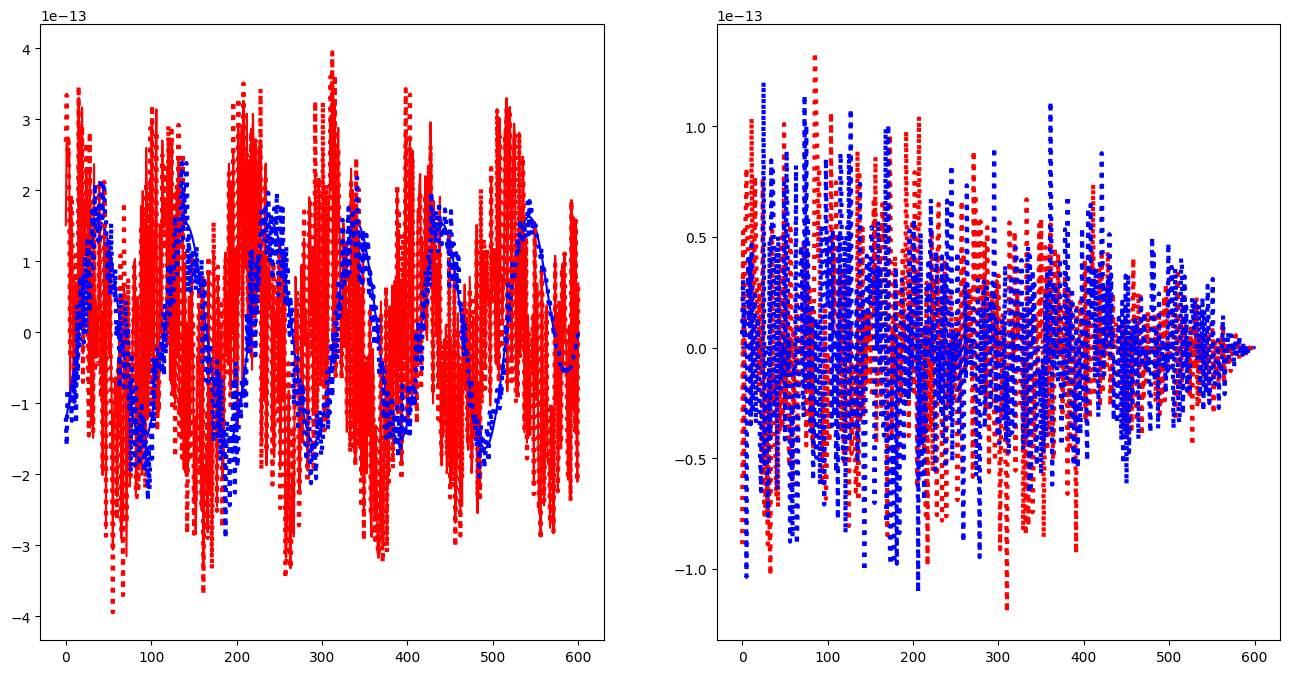

MAX GRADIENT =  3.4142379140481487e-13
Optimal control with target oscillation period
Compute control for a deterministic system
Cost in iteration 0: -119.97684239254724
Final cost : -119.97684529761604
Compute control for a deterministic system
Cost in iteration 0: -119.97684529761604
Converged in iteration 4 with cost -119.97684529761614
Final cost : -119.97684529761614
Compute control for a deterministic system
Cost in iteration 0: -119.97684529761614
Cost in iteration 100: -119.97880573380115
Final cost : -119.97880573380115
Compute control for a deterministic system
Cost in iteration 0: -119.97880573380115
Cost in iteration 100: -120.09889768717883
Final cost : -120.09889768717883
Compute control for a deterministic system
Cost in iteration 0: -120.09889768717883
Cost in iteration 100: -120.099302229935
Final cost : -120.099302229935
Compute control for a deterministic system
Cost in iteration 0: -120.099302229935
Cost in iteration 100: -120.22528706381527
Final cost : -120.225287

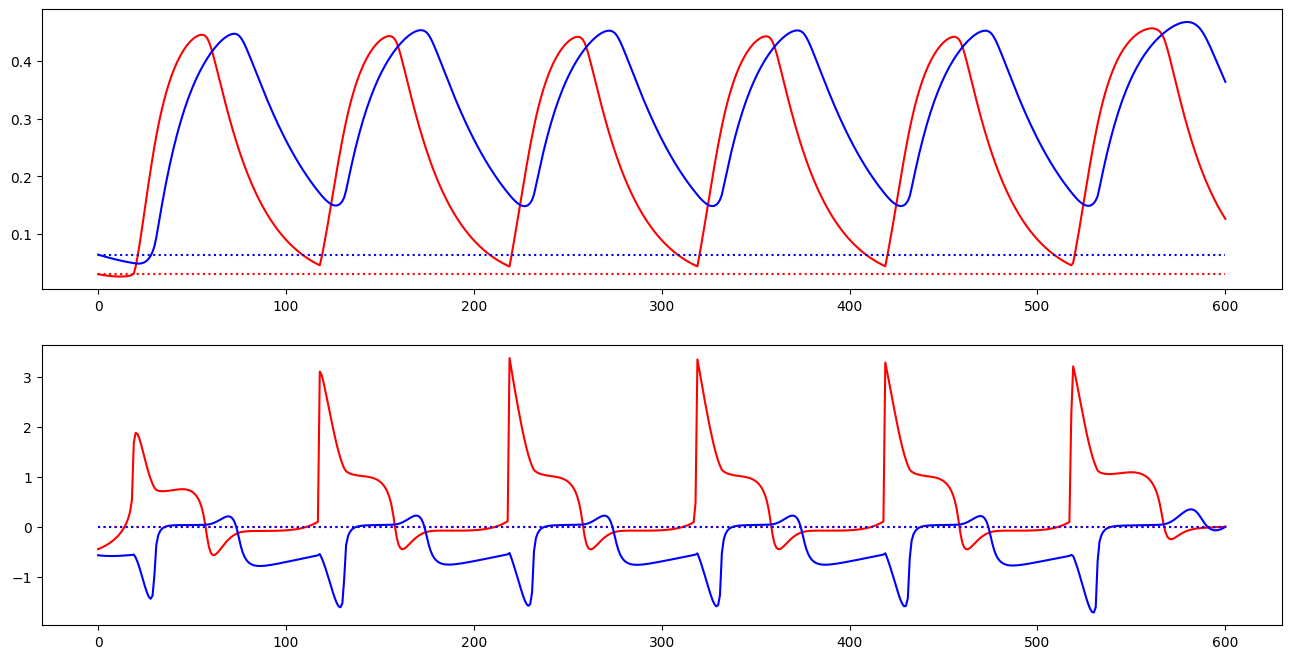

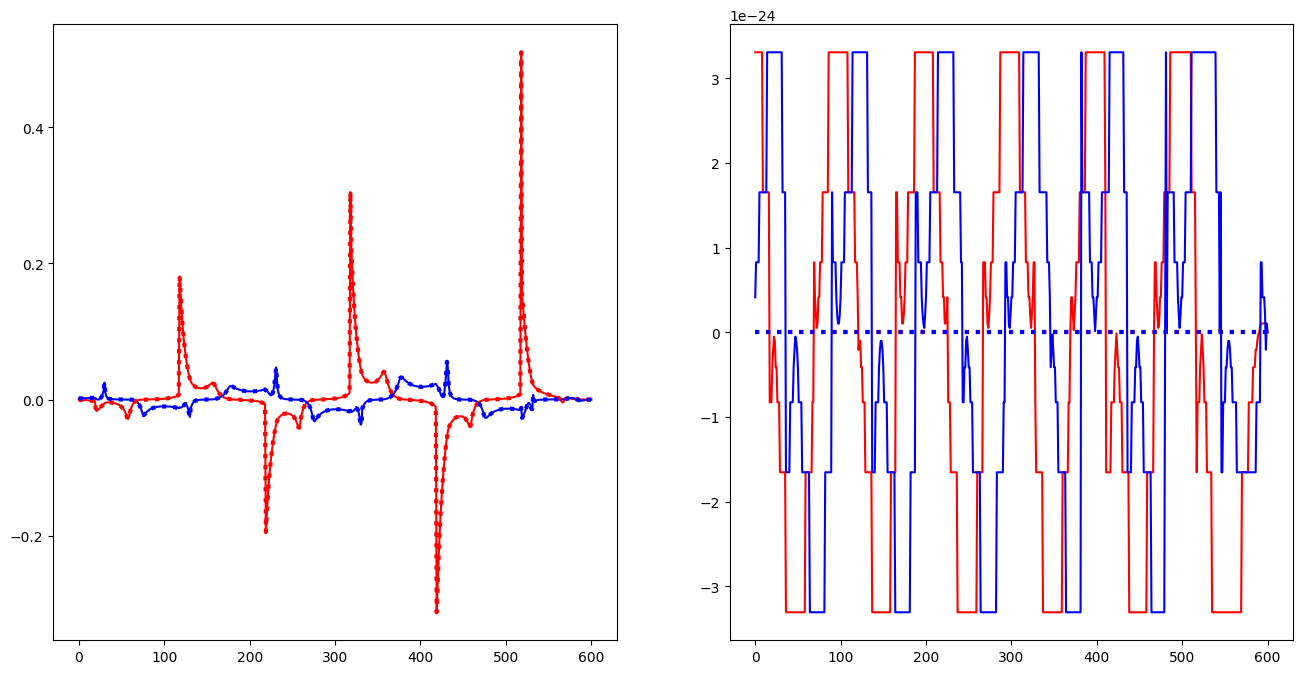

MAX GRADIENT =  0.5102126001840175
Optimal control with target oscillation period
Compute control for a deterministic system
Cost in iteration 0: -123.5108328318151
Final cost : -123.51085980935481
Compute control for a deterministic system
Cost in iteration 0: -123.51085980935481
Converged in iteration 3 with cost -123.51085980935497
Final cost : -123.51085980935497
Compute control for a deterministic system
Cost in iteration 0: -123.51085980935497
Cost in iteration 100: -123.57759703343064
Final cost : -123.57759703343064
Compute control for a deterministic system
Cost in iteration 0: -123.57759703343064
Cost in iteration 100: -123.78621931479829
Final cost : -123.78621931479829
Compute control for a deterministic system
Cost in iteration 0: -123.78621931479829
Cost in iteration 100: -123.87867846620463
Final cost : -123.87867846620463
Compute control for a deterministic system
Cost in iteration 0: -123.87867846620463
Cost in iteration 100: -123.87871802822887
Final cost : -123.87871

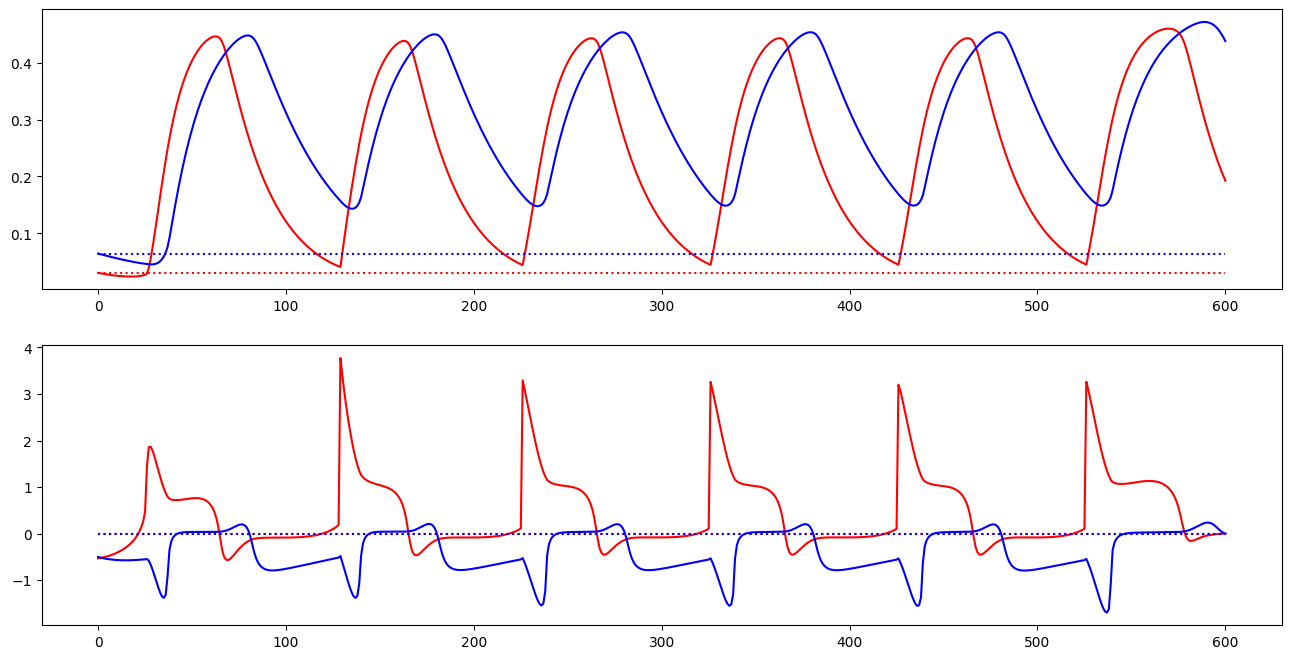

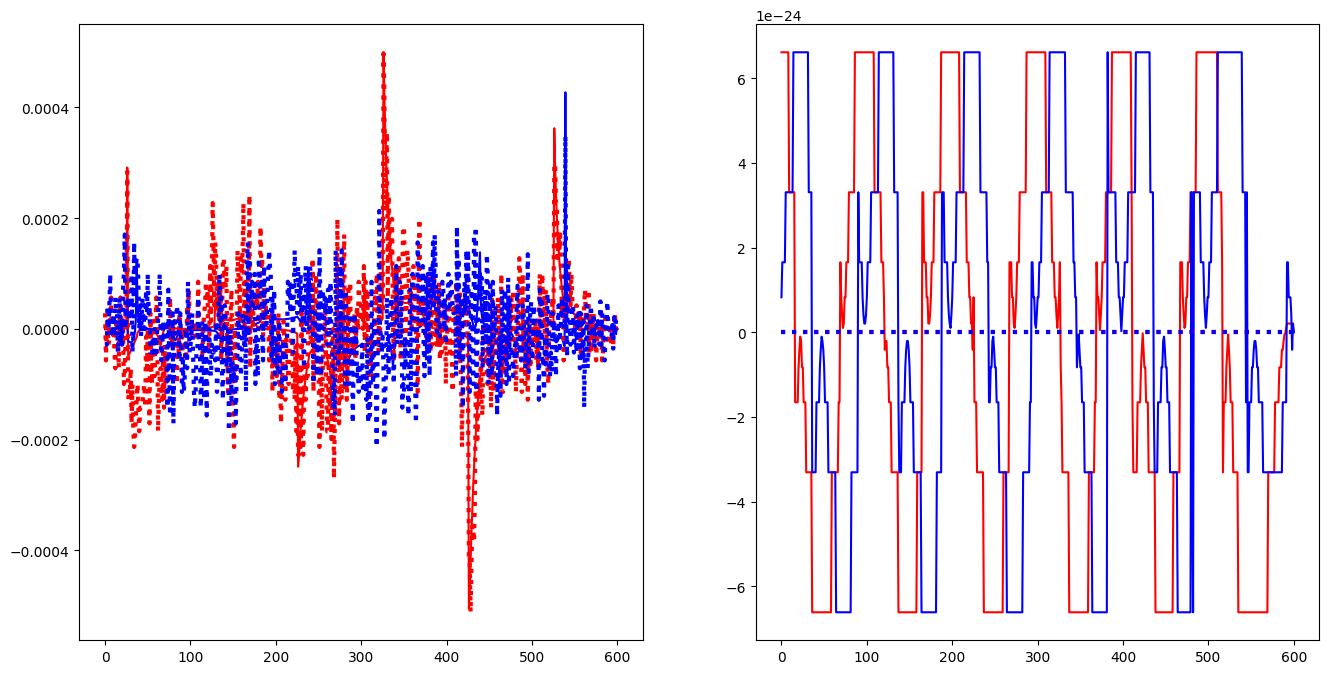

MAX GRADIENT =  0.0005048637954012669


In [146]:
for ui, u in enumerate(u_inits):

    #
    #if ui not in [0,1]: continue
    
    wc.params.exc_ext = u[:,0,:]
    wc.params.inh_ext = u[:,1,:]

    wc_controlled = oc_wc.OcWc(wc, target_period, print_array=np.arange(0,1000,100),
                                  cost_interval=(0,None), control_interval=(0,None), grad_method=0)

    #wc_controlled.channelwise_optimization = True
    
    #for factor in np.random.random(20):
    for factor in [1]:

        wc_controlled.weights["w_2"] = 1. * factor
        wc_controlled.weights["w_p"] = 0.
        wc_controlled.weights["w_f"] = 1e4

        if True:
            if type(res_control[wc_controlled.grad_method][ui]) is not type(None):
                wc_controlled.control = res_control[wc_controlled.grad_method][ui].copy()
                wc_controlled.update_input()
                wc_controlled.optimize(1)

        wc_controlled.grad_method = 0

        for k in range(1):
            for exp in np.arange(-12, 14, 4):
                wc_controlled.zero_step_encountered = False
                wc_controlled.step = 10.**exp
                wc_controlled.optimize(100)

    wc_controlled.grad_method = 0
    wc_controlled.weights["w_2"] = 1.

    for k in range(0):
        for exp in np.arange(-15, 15, 1):
            wc_controlled.zero_step_encountered = False
            wc_controlled.step = 10.**exp
            wc_controlled.optimize(100)

    if True:
        res_cost[wc_controlled.grad_method, ui] =  wc_controlled.cost_history[-1]   
        res_control[wc_controlled.grad_method][ui] = wc_controlled.control.copy()
        res_state[wc_controlled.grad_method][ui] = wc_controlled.get_xs().copy()

    xs = wc_controlled.get_xs()
    control = wc_controlled.control.copy()

    fig, ax = plt.subplots(2,1, figsize=(16,8))
    ax[0].plot(xs[0,0,:], color="red")
    ax[0].plot(xs[0,1,:], color="blue")
    ax[0].plot(xs[1,0,:], color="red", linestyle=":")
    ax[0].plot(xs[1,1,:], color="blue", linestyle=":")

    ax[1].plot(control[0,0,:], color="red")
    ax[1].plot(control[0,1,:], color="blue")
    ax[1].plot(control[1,0,:], color="red", linestyle=":")
    ax[1].plot(control[1,1,:], color="blue", linestyle=":")
    plt.show()

    grad_num = wc_controlled.compute_gradient_num()
    grad_an = wc_controlled.compute_gradient()

    fig, ax = plt.subplots(1,2, figsize=(16,8))
    ax[0].plot(grad_an[0,0,:], color="red")
    ax[0].plot(grad_an[0,1,:], color="blue")
    ax[1].plot(grad_an[1,0,:], color="red")
    ax[1].plot(grad_an[1,1,:], color="blue")
    ax[0].plot(grad_num[0,0,:], color="red", linestyle=":", linewidth=3)
    ax[0].plot(grad_num[0,1,:], color="blue", linestyle=":", linewidth=3)
    ax[1].plot(grad_num[1,0,:], color="red", linestyle=":", linewidth=3)
    ax[1].plot(grad_num[1,1,:], color="blue", linestyle=":", linewidth=3)
    plt.show()

    print("MAX GRADIENT = ", np.amax(np.abs(wc_controlled.gradient)))

In [84]:
print(res_cost)

[[0.04602724 0.04602725 0.04602689 0.04602733 0.04602732]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]]


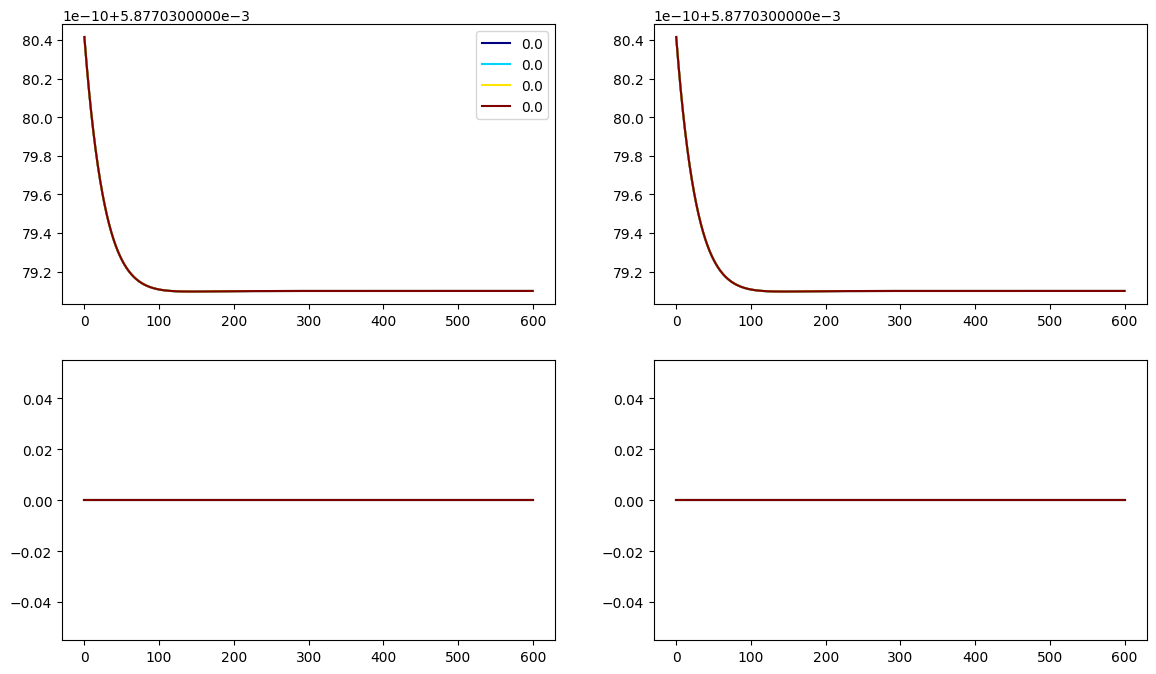

In [113]:
cmap = plt.cm.get_cmap("jet")
fig, ax = plt.subplots(2, 2, figsize=(14,8))

gradmet = 0

for init_i in range(len(u_inits)):
    col = cmap(init_i/(len(u_inits)-1))
    ax[0,0].plot(res_state[gradmet][init_i][0,0,:], color=col, label=np.around(res_cost[gradmet][init_i], 6))
    ax[0,1].plot(res_state[gradmet][init_i][1,0,:], color=col)
    ax[1,0].plot(res_control[gradmet][init_i][0,0,:], color=col)
    ax[1,1].plot(res_control[gradmet][init_i][1,0,:], color=col)

ax[0,0].legend(loc="upper right")

In [ ]:
for ui in range(len(u_inits)):
    amp = np.amax(res_control[ui][0,0,:]) - np.amin(res_control[ui][0,0,:])
    print(amp * wc_controlled.weights["w_2"] * np.pi / wc_controlled.weights["w_f"])

TypeError: list indices must be integers or slices, not tuple